## **Analyse Dataset Varience**
Training on high-dimensional datasets requires a significant amount of time and computational resources. Twinlab provides an option to specify the number of dimensions or the amount of variance you wish to train on. This allows you to create more lightweight models.
This notebook will explain how to utilize the `analyse_input_variance` and `analyse_output_variance` methods on your dataset to make informed decisions about the model you wish to train.

In [41]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin

# twinLab import
import twinlab as tl

In [42]:
tl.versions()

{'message': 'Endpoint request timed out'}

In [43]:
# Define the df you want to use
# write more intresting fucntions and use numpy rather than maths
list1 = list(range(100))
example_df = pd.DataFrame({"A":list1, "B": [i**2 for i in list1],"C":[i**3-sin(i) for i in list1]})
example_df

,A,B,C
0,0,0,0.000000
1,1,1,0.158529
2,2,4,7.090703
3,3,9,26.858880
4,4,16,64.756802
...,...,...,...
95,95,9025,857374.316738
96,96,9216,884735.016412
97,97,9409,912672.620392
98,98,9604,941192.573382


Write that the purpose of this is to catch correlations in the data so we can train on less dimensions and reatain infromation 

In [40]:
# define a dataset
# change this to a sensible name 
example_dataset = tl.Dataset("example")

# Upload Your dataset
example_dataset.upload(df=example_df)
print(example_dataset.view())
print(example_dataset.summarise())

     A     B              C
0    0     0       0.000000
1    1     1       0.158529
2    2     4       7.090703
3    3     9      26.858880
4    4    16      64.756802
..  ..   ...            ...
95  95  9025  857374.316738
96  96  9216  884735.016412
97  97  9409  912672.620392
98  98  9604  941192.573382
99  99  9801  970299.999207

[100 rows x 3 columns]
                A            B              C
count  100.000000   100.000000     100.000000
mean    49.500000  3283.500000  245024.996208
std     29.011492  2968.174804  280457.604901
min      0.000000     0.000000       0.000000
25%     24.750000   612.750000   15175.075658
50%     49.500000  2450.500000  121325.108064
75%     74.250000  5513.250000  409387.585805
max     99.000000  9801.000000  970299.999207


In [35]:
# deleting the dataset
example_dataset.delete()

NameError: name 'example_dataset' is not defined

In [ ]:
# Upload fusion dataset and train on it after PCA
training_dataset = pd.DataFrame()

In [ ]:
# Preform input analys
training_dataset.analyse_input_variance(columns=["A","B","C"])

{'message': 'A dataset must be uploaded in order to run an analysis on it.'}


KeyError: 'dataframe not in API response body'

In [ ]:
# plot the montonic fucntion of the information retained per variable

In [ ]:
# Perform output analysis
# TODO: find out why you would perform output analysis shouldn't the outputs be fixed 
emulator = tl.Emulator("Micla")
emulator.train()

In [ ]:
# Train the dataset 

### **Problem Formulation**

Here, we will formulate an exact function to do regression on, and subsequently add noise to the data.


In [ ]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2


X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)  # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

### **Homoskedastic GP Emulator**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="fixed_noise_gp"` which must be provided to the `estimator_params` within the `TrainParams` object during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and added to the `TrainParams` object. This additional table must contain the same columns as the mean data. Since the noise model is homoskedastic, the noise must be the same value everywhere.


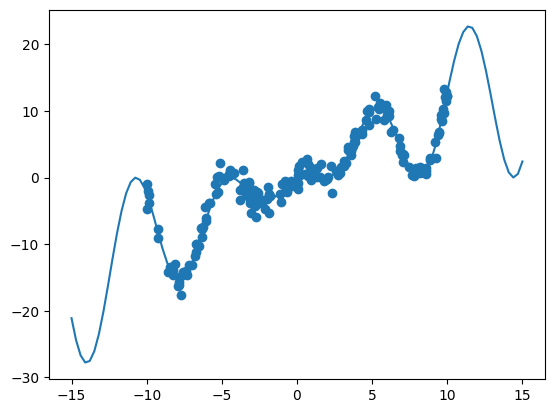

In [ ]:
noise_scale = 1.0

# Add noise to data
y_data_homoskedastic = y_data + np.random.normal(scale=noise_scale, size=X_data.shape)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_homoskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": np.full_like(y_data_homoskedastic, noise_scale)})

plt.plot(X, y)
plt.scatter(X_data, y_data_homoskedastic)
plt.show()

In [ ]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
dataset = tl.Dataset(dataset_id)
dataset.upload(df)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
std_dataset = tl.Dataset(std_dataset_id)
std_dataset.upload(df_stdev)

In [ ]:
# Initialise emulator
emulator_id = "HomoskedasticGP"
emulator = tl.Emulator(emulator_id)

# Define the training and estimator parameters
estimator_params = tl.EstimatorParams(estimator_type="fixed_noise_gp")
params = tl.TrainParams(dataset_std=std_dataset, estimator_params=estimator_params)

# Begin training the emulator
emulator.train(dataset, ["x"], ["y"], params)

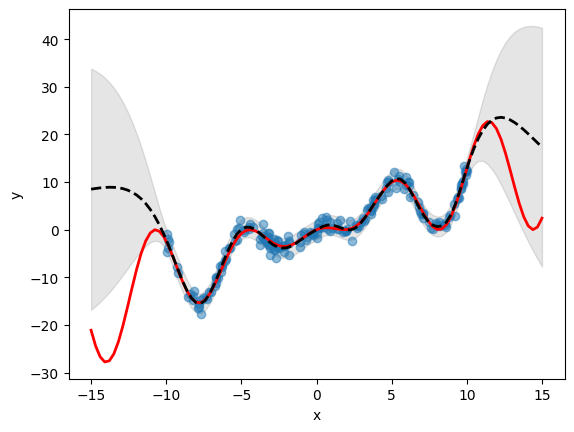

In [ ]:
#  Define an evaluation dataset and predicts the outputs using the emulator
eval_data = pd.DataFrame(X, columns=["x"])
df_mean, df_stdev = emulator.predict(eval_data)
y_mean, y_stdev = df_mean.values, df_stdev.values

# Plot inference results
plt.fill_between(
    X.flatten(),
    (y_mean - 1.96 * y_stdev).flatten(),
    (y_mean + 1.96 * y_stdev).flatten(),
    color="k",
    alpha=0.1,
)

plt.scatter(df["x"], df["y"], alpha=0.5, label="Training Data")
plt.xlabel("x")
plt.ylabel("y")

plt.plot(X, y, c="r", linewidth=2)
plt.plot(X, y_mean, c="k", linewidth=2, linestyle="dashed")
plt.show()

### **Heteroskedastic GP Emulator**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="heteroskedastic_gp"` which must be provided to the `estimator_params` within the `TrainParams` object during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and added to the `TrainParams` object. This additional table must contain the same columns as the mean data. Since the noise model is homoskedastic, the noise must be the same value everywhere.


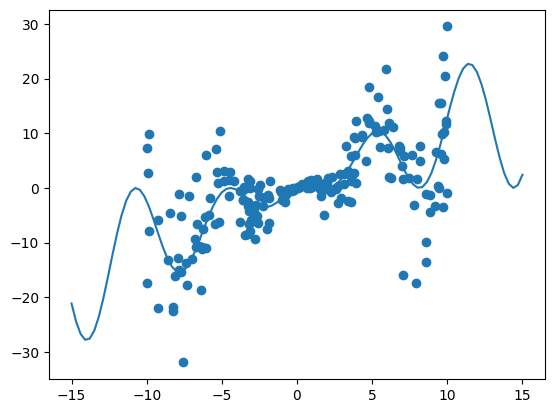

In [ ]:
noise_scale = 0.5

# Add noise to data
y_data_heteroskedastic = (
    y_data + np.random.normal(scale=noise_scale, size=X_data.shape[0]) * X_data * 2
)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_heteroskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": X_data * 2})

plt.plot(X, y)
plt.scatter(X_data, y_data_heteroskedastic)
plt.show()

In [ ]:
# Delete emulator and dataset
emulator.delete()
trianing_dataset.delete()